In [2]:
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import talib 
import math
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from arch import arch_model
from statsmodels.tsa import stattools
from sklearn import svm
import os

In [3]:
#读取数据
df=pd.read_csv(input())#输入数据文件路径，例如D:\data\data.csv
df.columns=['code','Date','price','return_','vwdret']

print(df)

D:\data\data.csv
       code   Date    price   return_    vwdret
0         1    103   8.5625  0.007353 -0.006801
1         1    104   8.4375 -0.014599 -0.039658
2         1    105   8.5625  0.014815 -0.000936
3         1    106   8.5000 -0.007299 -0.007392
4         1    107   8.4375 -0.007353  0.032524
...     ...    ...      ...       ...       ...
13805   145  50624  36.7000 -0.018454 -0.006613
13806   145  50627  36.3000 -0.010899 -0.000429
13807   145  50628  36.9700  0.018457  0.009692
13808   145  50629  36.9300 -0.001082 -0.000378
13809   145  50630  36.6300 -0.008123 -0.005904

[13810 rows x 5 columns]


In [4]:
#按组筛选数据
def df_code(i,p):
    code_i=df[(df['code']==i) &(p)]
    return code_i

In [5]:
def ma_2(i1,i2,i3,p):
    price= df_code(i1,p).price
    ret=df_code(i1,p).return_
    vwdret=df_code(i1,p).vwdret

    df1 = talib.MA(np.array(price), timeperiod=i2)
    mavgi2=df1
    df2 = talib.MA(np.array(price), timeperiod=i3)
    mavgi3=df2
    #处理信号
    price.index=range(len(price))
    ret.index=range(len(ret))
    vwdret.index=range(len(vwdret))
    SmaSignal=pd.Series(0,index=price.index)#建立一个值全是0，索引为对应收盘价序列的时间Series序列
    s=0#初始化参数，统计多头天数  
    k=0#t统计触发次数             
    for i in range(i3,len(price)):
        if all([price[i]>mavgi2[i],price[i-1]<mavgi2[i-1]]):#([mavgi2[i]>mavgi3[i],mavgi2[i-1]<mavgi3[i-1]]):# 买入条件
            SmaSignal[i]=1     #更新序列，买入 为1
            k+=1  
        elif all([mavgi2[i]<mavgi3[i],mavgi2[i-1]>mavgi3[i-1]]):#卖出信号   
            SmaSignal[i]=0     #卖出为空
            k+=1
        else:
            SmaSignal[i]=SmaSignal[i-1]  #两个if都没执行，不做任何操作
        s=s+SmaSignal[i]      #做多天数
        ds=len(price)-s       #做空天数
    

    SmaTrade=SmaSignal.shift(1).dropna()
    SmaRet=ret*SmaTrade.dropna()  #将股价变动×信号序列，信号序列只有0  或 1 ，对应做多，做空。

    #股票累积收益率
    cumStock=np.cumprod(1+ret[SmaRet.index[0:]])-1
    cumMarket=np.cumprod(1+vwdret)-1
    #策略累积收益率
    cumTrade=np.cumprod(1+SmaRet)-1
    plt.plot(cumTrade,label="cumTrade2",color='r',linestyle=':')
    plt.plot(cumStock,label="cumStock",color='k')
    plt.plot(cumMarket,label="cumMarket",color='y')
    plt.legend()
    SmaTrade.to_csv('D:\\data\\trade\\smatrade%d'%i1+'.csv')
    SmaRet.to_csv('D:\\data\\ret\\smaret%d'%i1+'.csv')
    cumTrade.to_csv('D:\\data\\cumtrade\\smacumtrade%d'%i1+'.csv')
    print("操作{}次,空头天数{},多头天数{}".format(k,s,ds))
    print(cumTrade)

In [6]:
def magarch2(i1,i2,i3,p):
    ret_=df_code(i1,df['Date']>0).return_
    price= df_code(i1,p).price
    ret=df_code(i1,p).return_

    df1 = talib.MA(np.array(price), timeperiod=i2)
    mavgi2=df1
    df2 = talib.MA(np.array(price), timeperiod=i3)
    mavgi3=df2
    #处理信号
    price.index=range(len(price))
    ret.index=range(len(ret))
    SmaSignal=pd.Series(0,index=price.index)#建立一个值全是0，索引为对应收盘价序列的时间Series序列
    s=0#初始化参数，统计多头天数  
    k=0#t统计触发次数             
    for i in range(i3,len(price)):
        if all([price[i]>mavgi2[i],price[i-1]<mavgi2[i-1]]):# 买入条件
            SmaSignal[i]=1      #更新序列，买入 为1
            k+=1  
        elif all([mavgi2[i]<mavgi3[i],mavgi2[i-1]>mavgi3[i-1]]):#卖出信号   
            SmaSignal[i]=0     #卖出为空
            k+=1
        else:
            SmaSignal[i]=SmaSignal[i-1]  #两个if都没执行，不做任何操作
        s=s+SmaSignal[i]      #做多天数
        ds=len(price)-s       #做空天数
    
    SmaTrade=SmaSignal.shift(1).dropna()
   
    garch=arch_model(y=ret_,mean='Constant',lags=0,vol='GARCH',p=1,o=0,q=1,dist='normal')
    garchmodel=garch.fit()
    vol_garch=np.zeros(len(price)-1)
    vol_garch[0]=np.array(ret_)[:1].std() #之前的数据计算波动率作为预测起始日波动率
    u60=ret[-len(price):]
    for a in range(len(price)-2):
        vol_garch[a+1]=np.sqrt(garchmodel.params[1]+garchmodel.params[2]*np.array(u60)[a]**2+garchmodel.params[3]*vol_garch[a]**2)
    vol_ma2=vol_garch*SmaTrade
    plt.scatter(x=range(len(vol_ma2)),y=vol_ma2,label='vol_ma2',color='r')
    vol_ma2.to_csv('D:\\data\\vol\\smavol%d'%i1+'.csv')
    print (vol_ma2.mean())

操作12次,空头天数86,多头天数39
0           NaN
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
120    0.370551
121    0.306741
122    0.293860
123    0.275046
124    0.309781
Length: 125, dtype: float64


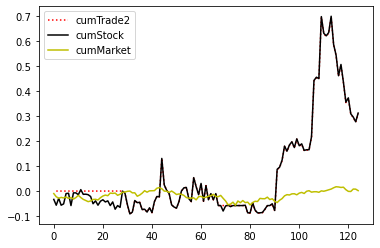

In [7]:

ma_2(1,12,26,df['Date']>50000)

操作16次,空头天数78,多头天数47
0           NaN
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
120   -0.100301
121   -0.100301
122   -0.100301
123   -0.100301
124   -0.100301
Length: 125, dtype: float64


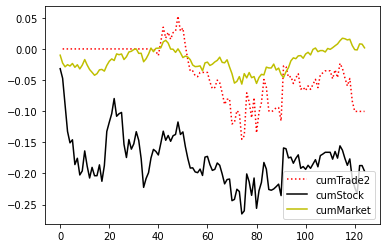

In [8]:

ma_2(2,12,26,df['Date']>50000)

操作6次,空头天数81,多头天数44
0           NaN
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
120   -0.637932
121   -0.655174
122   -0.637932
123   -0.655174
124   -0.637932
Length: 125, dtype: float64


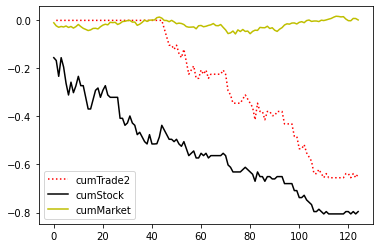

In [9]:

ma_2(12,12,26,df['Date']>50000)

操作9次,空头天数90,多头天数35
0           NaN
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
120   -0.078243
121   -0.079226
122   -0.095922
123   -0.094940
124   -0.093467
Length: 125, dtype: float64


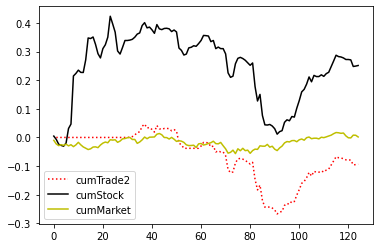

In [10]:

ma_2(25,12,26,df['Date']>50000)

操作17次,空头天数91,多头天数34
0           NaN
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
120   -0.015262
121   -0.051599
122   -0.011628
123   -0.023256
124   -0.037064
Length: 125, dtype: float64


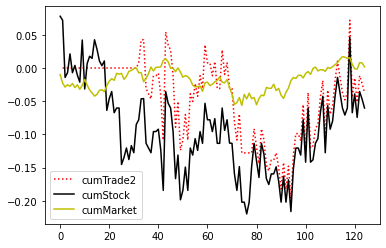

In [11]:

ma_2(28,12,26,df['Date']>50000)

操作10次,空头天数86,多头天数39
0           NaN
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
120    0.243385
121    0.255661
122    0.279044
123    0.295996
124    0.286058
Length: 125, dtype: float64


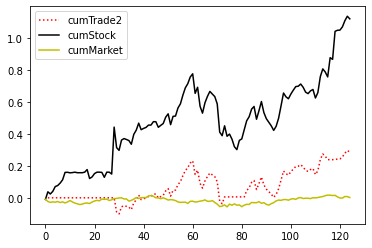

In [12]:

ma_2(44,12,26,df['Date']>50000)

操作10次,空头天数64,多头天数61
0           NaN
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
120   -0.085767
121   -0.074685
122   -0.054369
123   -0.052522
124   -0.069145
Length: 125, dtype: float64


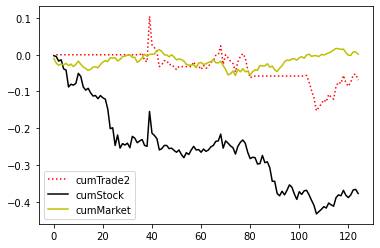

In [13]:

ma_2(51,12,26,df['Date']>50000)

操作12次,空头天数79,多头天数46
0           NaN
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
120   -0.077833
121   -0.074882
122   -0.053487
123    0.001105
124   -0.026192
Length: 125, dtype: float64


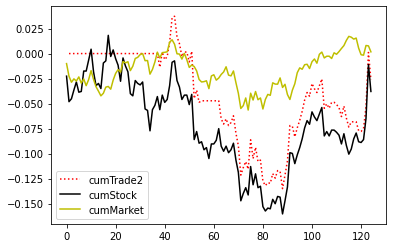

In [14]:

ma_2(104,12,26,df['Date']>50000)

操作10次,空头天数66,多头天数59
0           NaN
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
120    0.053893
121    0.072126
122    0.092548
123    0.093278
124    0.082338
Length: 125, dtype: float64


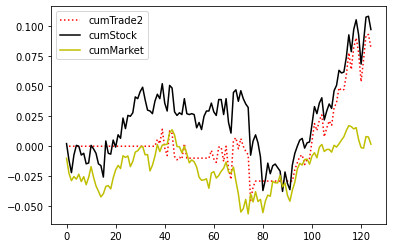

In [15]:
ma_2(119,12,26,df['Date']>50000)

操作9次,空头天数75,多头天数50
0           NaN
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
120   -0.074892
121   -0.084975
122   -0.068086
123   -0.069095
124   -0.076656
Length: 125, dtype: float64


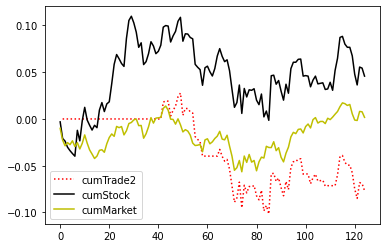

In [16]:

ma_2(145,12,26,df['Date']>50000)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1316450209.295282
Iteration:      2,   Func. Count:     18,   Neg. LLF: 3245.8403952003655
Iteration:      3,   Func. Count:     27,   Neg. LLF: 85567042.16780446
Iteration:      4,   Func. Count:     39,   Neg. LLF: 849.394081299713
Iteration:      5,   Func. Count:     48,   Neg. LLF: 98738213.34369768
Iteration:      6,   Func. Count:     60,   Neg. LLF: 27209.084297559875
Iteration:      7,   Func. Count:     68,   Neg. LLF: 1351.1103701200052
Iteration:      8,   Func. Count:     77,   Neg. LLF: 2136.4081188046143
Iteration:      9,   Func. Count:     86,   Neg. LLF: 10177.388970750799
Iteration:     10,   Func. Count:     93,   Neg. LLF: -3015.3924183186273
Iteration:     11,   Func. Count:     99,   Neg. LLF: -2911.3034976170575
Iteration:     12,   Func. Count:    106,   Neg. LLF: -2918.224539427063
Iteration:     13,   Func. Count:    113,   Neg. LLF: -2930.1584811867297
Iteration:     14,   Func. Count:    120,   Neg. LLF:

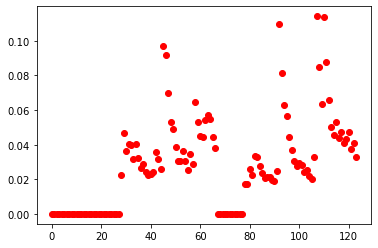

In [17]:
magarch2(1,12,26,df['Date']>50000)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 36124551.91750425
Iteration:      2,   Func. Count:     18,   Neg. LLF: 202694414.79392803
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3061.5487624336693
            Iterations: 3
            Function evaluations: 25
            Gradient evaluations: 2
0.01562897176454051


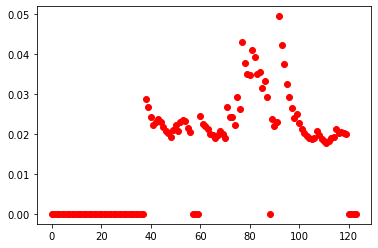

In [18]:
magarch2(2,12,26,df['Date']>50000)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 429710.05301561666
Iteration:      2,   Func. Count:     17,   Neg. LLF: 19176.383687561283
Iteration:      3,   Func. Count:     24,   Neg. LLF: -1800.7005495547705
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1335.5719888477247
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1693.0462519986795
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1887.396796960423
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1889.7172050682743
Iteration:      8,   Func. Count:     56,   Neg. LLF: -1889.7172090201598
Iteration:      9,   Func. Count:     60,   Neg. LLF: -1889.7172090201507
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1889.7172090201598
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 9
0.03754311046264031


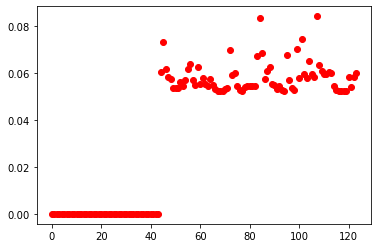

In [19]:
magarch2(12,12,26,df['Date']>50000)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 794797832.8406769
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2251446.8543477287
Iteration:      3,   Func. Count:     28,   Neg. LLF: -3127.8527658270227
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3127.852770236355
            Iterations: 7
            Function evaluations: 28
            Gradient evaluations: 3
0.016442000719355185


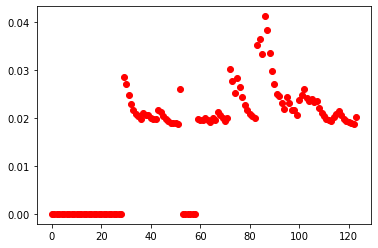

In [20]:
magarch2(25,12,26,df['Date']>50000)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 159228535.9146755
Iteration:      2,   Func. Count:     17,   Neg. LLF: -653.783694044673
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1817.036727029126
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1044.257450913119
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2900.082446339181
Iteration:      6,   Func. Count:     43,   Neg. LLF: -1749.9553743393112
Iteration:      7,   Func. Count:     49,   Neg. LLF: -1831.6041869885066
Iteration:      8,   Func. Count:     54,   Neg. LLF: -1831.8130150438192
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1831.8479745861102
Iteration:     10,   Func. Count:     64,   Neg. LLF: -1831.8693567718042
Iteration:     11,   Func. Count:     69,   Neg. LLF: -1831.869490639342
Iteration:     12,   Func. Count:     73,   Neg. LLF: -1831.8694911223251
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1831.869490639342
            I

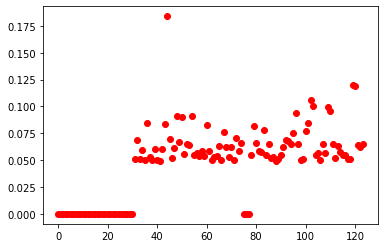

In [21]:
magarch2(28,12,26,df['Date']>50000)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12117296.46941181
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1943.7871631538892
Iteration:      3,   Func. Count:     25,   Neg. LLF: -695.138436231098
Iteration:      4,   Func. Count:     33,   Neg. LLF: 4046.1828039718084
Iteration:      5,   Func. Count:     42,   Neg. LLF: -2593.103705487234
Iteration:      6,   Func. Count:     48,   Neg. LLF: -2689.25791375678
Iteration:      7,   Func. Count:     54,   Neg. LLF: -2609.8455730153946
Iteration:      8,   Func. Count:     60,   Neg. LLF: -2690.2349142034136
Iteration:      9,   Func. Count:     66,   Neg. LLF: -2697.0074292665877
Iteration:     10,   Func. Count:     72,   Neg. LLF: -2697.283893953595
Iteration:     11,   Func. Count:     77,   Neg. LLF: -2697.2851835272622
Iteration:     12,   Func. Count:     82,   Neg. LLF: -2697.285204577307
Iteration:     13,   Func. Count:     87,   Neg. LLF: -2697.2852075655383
Iteration:     14,   Func. Count:     91,   Neg.

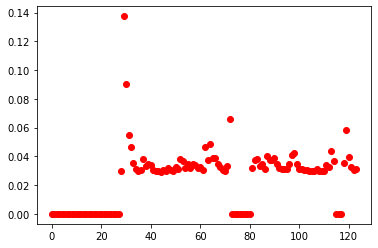

In [22]:
magarch2(44,12,26,df['Date']>50000)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8617492.536938917
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1608928.208655196
Iteration:      3,   Func. Count:     27,   Neg. LLF: -2378.275181274236
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2378.275184603247
            Iterations: 7
            Function evaluations: 27
            Gradient evaluations: 3
0.017029137362511788


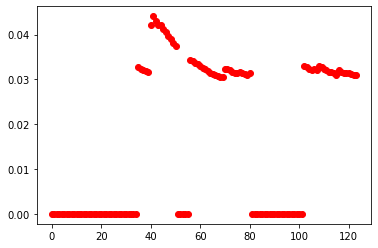

In [23]:
magarch2(51,12,26,df['Date']>50000)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 60153773.49212524
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4.6542249504626765e+17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2795.204690685743
            Iterations: 2
            Function evaluations: 27
            Gradient evaluations: 2
0.012487047157864065


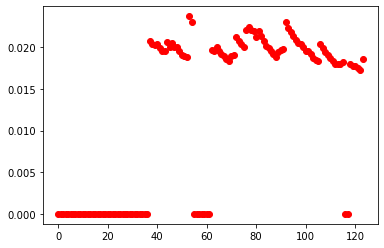

In [24]:
magarch2(104,12,26,df['Date']>50000)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 54130777.49928404
Iteration:      2,   Func. Count:     18,   Neg. LLF: 50373.79745533848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3438.4564209179853
            Iterations: 2
            Function evaluations: 25
            Gradient evaluations: 2
0.008085478805014656


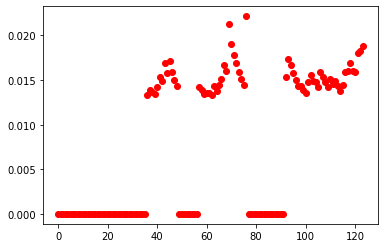

In [25]:
magarch2(119,12,26,df['Date']>50000)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 793433537.8717427
Iteration:      2,   Func. Count:     18,   Neg. LLF: 142481789.93217963
Iteration:      3,   Func. Count:     29,   Neg. LLF: -3222.4907190294707
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3222.4907188770994
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
0.01098348527264176


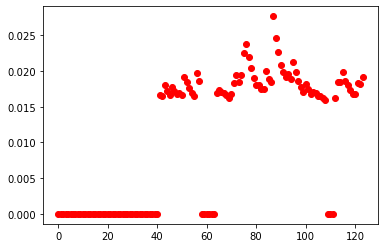

In [26]:
magarch2(145,12,26,df['Date']>50000)

In [27]:
trade1=pd.read_csv(r'D:\data\trade\smatrade1.csv')
trade2=pd.read_csv(r'D:\data\trade\smatrade2.csv')
trade12=pd.read_csv(r'D:\data\trade\smatrade12.csv')
trade25=pd.read_csv(r'D:\data\trade\smatrade25.csv')
trade28=pd.read_csv(r'D:\data\trade\smatrade28.csv')
trade44=pd.read_csv(r'D:\data\trade\smatrade44.csv')
trade51=pd.read_csv(r'D:\data\trade\smatrade51.csv')
trade104=pd.read_csv(r'D:\data\trade\smatrade104.csv')
trade119=pd.read_csv(r'D:\data\trade\smatrade119.csv')
trade145=pd.read_csv(r'D:\data\trade\smatrade145.csv')
trade=pd.concat([trade1.iloc[:,1],trade2.iloc[:,1],trade12.iloc[:,1],trade25.iloc[:,1],trade28.iloc[:,1],trade44.iloc[:,1],trade51.iloc[:,1],trade104.iloc[:,1],trade119.iloc[:,1],trade145.iloc[:,1]],axis=1,ignore_index=True)


In [28]:
ret1=pd.read_csv(r'D:\data\ret\smaret1.csv')
ret2=pd.read_csv(r'D:\data\ret\smaret2.csv')
ret12=pd.read_csv(r'D:\data\ret\smaret12.csv')
ret25=pd.read_csv(r'D:\data\ret\smaret25.csv')
ret28=pd.read_csv(r'D:\data\ret\smaret28.csv')
ret44=pd.read_csv(r'D:\data\ret\smaret44.csv')
ret51=pd.read_csv(r'D:\data\ret\smaret51.csv')
ret104=pd.read_csv(r'D:\data\ret\smaret104.csv')
ret119=pd.read_csv(r'D:\data\ret\smaret119.csv')
ret145=pd.read_csv(r'D:\data\ret\smaret145.csv')
ret=pd.concat([ret1.iloc[:,1],ret2.iloc[:,1],ret12.iloc[:,1],ret25.iloc[:,1],ret28.iloc[:,1],ret44.iloc[:,1],ret51.iloc[:,1],ret104.iloc[:,1],ret119.iloc[:,1],ret145.iloc[:,1]],axis=1,ignore_index=True)


In [29]:
cumtrade1=pd.read_csv(r'D:\data\cumtrade\smacumtrade1.csv')
cumtrade2=pd.read_csv(r'D:\data\cumtrade\smacumtrade2.csv')
cumtrade12=pd.read_csv(r'D:\data\cumtrade\smacumtrade12.csv')
cumtrade25=pd.read_csv(r'D:\data\cumtrade\smacumtrade25.csv')
cumtrade28=pd.read_csv(r'D:\data\cumtrade\smacumtrade28.csv')
cumtrade44=pd.read_csv(r'D:\data\cumtrade\smacumtrade44.csv')
cumtrade51=pd.read_csv(r'D:\data\cumtrade\smacumtrade51.csv')
cumtrade104=pd.read_csv(r'D:\data\cumtrade\smacumtrade104.csv')
cumtrade119=pd.read_csv(r'D:\data\cumtrade\smacumtrade119.csv')
cumtrade145=pd.read_csv(r'D:\data\cumtrade\smacumtrade145.csv')
cumtrade=pd.concat([cumtrade1.iloc[:,1],cumtrade2.iloc[:,1],cumtrade12.iloc[:,1],cumtrade25.iloc[:,1],cumtrade28.iloc[:,1],cumtrade44.iloc[:,1],cumtrade51.iloc[:,1],cumtrade104.iloc[:,1],cumtrade119.iloc[:,1],cumtrade145.iloc[:,1]],axis=1,ignore_index=True)


In [30]:
vol1=pd.read_csv(r'D:\data\vol\smavol1.csv')
vol2=pd.read_csv(r'D:\data\vol\smavol2.csv')
vol12=pd.read_csv(r'D:\data\vol\smavol12.csv')
vol25=pd.read_csv(r'D:\data\vol\smavol25.csv')
vol28=pd.read_csv(r'D:\data\vol\smavol28.csv')
vol44=pd.read_csv(r'D:\data\vol\smavol44.csv')
vol51=pd.read_csv(r'D:\data\vol\smavol51.csv')
vol104=pd.read_csv(r'D:\data\vol\smavol104.csv')
vol119=pd.read_csv(r'D:\data\vol\smavol119.csv')
vol145=pd.read_csv(r'D:\data\vol\smavol145.csv')
vol=pd.concat([vol1.iloc[:,1],vol2.iloc[:,1],vol12.iloc[:,1],vol25.iloc[:,1],vol28.iloc[:,1],vol44.iloc[:,1],vol51.iloc[:,1],vol104.iloc[:,1],vol119.iloc[:,1],vol145.iloc[:,1]],axis=1,ignore_index=True)


In [31]:
trade_=np.array(trade)
ret_=np.array(ret)
vol_=np.array(vol)
cumtrade_=np.array(cumtrade)

In [32]:
p1=df_code(1,df['Date']>50000).iloc[0,2]
p2=df_code(2,df['Date']>50000).iloc[0,2]
p12=df_code(12,df['Date']>50000).iloc[0,2]
p25=df_code(25,df['Date']>50000).iloc[0,2]
p28=df_code(28,df['Date']>50000).iloc[0,2]
p44=df_code(44,df['Date']>50000).iloc[0,2]
p51=df_code(51,df['Date']>50000).iloc[0,2]
p104=df_code(104,df['Date']>50000).iloc[0,2]
p119=df_code(119,df['Date']>50000).iloc[0,2]
p145=df_code(145,df['Date']>50000).iloc[0,2]
p=np.array([p1,p2,p12,p25,p28,p44,p51,p104,p119,p145])


In [39]:
q=np.array([3,0,1,0,2,5,0,0,4,0])
e=np.array([1,0,1,0,1,1,0,0,1,0])
m=p*q.T
s=np.sum(m)

w1=m[0]/s
w2=m[1]/s
w12=m[2]/s
w25=m[3]/s
w28=m[4]/s
w44=m[5]/s
w51=m[6]/s
w104=m[7]/s
w119=m[8]/s
w145=m[9]/s

port=np.array([w1,w2,w12,w25,w28,w44,w51,w104,w119,w145])
port_ret=port.T*cumtrade_[-1]
port_trade=q.T*trade_
port_vol=e.T*trade_*vol_

result_trade=port_trade
result_ret=sum(port_ret)
result_vol=port_vol
result_volmax=result_vol.max()

print('每日持仓为',result_trade)
print('每日各股持仓波动率为',result_vol)
print('单只股票最大波动率为',result_volmax)
if result_volmax<0.2:
    print('风险在可控范围内')
else:
    print('风险较高')
print('最终收益率为',result_ret)

      

每日持仓为 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [3. 0. 1. ... 0. 4. 0.]
 [3. 0. 1. ... 0. 4. 0.]
 [3. 0. 1. ... 0. 4. 0.]]
每日各股持仓波动率为 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.03756313 0.         0.05389019 ... 0.         0.0179984  0.        ]
 [0.04104293 0.         0.05804026 ... 0.         0.0182655  0.        ]
 [0.03292062 0.         0.05972421 ... 0.         0.0187912  0.        ]]
单只股票最大波动率为 0.18392384129009245
风险在可控范围内
最终收益率为 0.1990300547066884
